In [ ]:
%matplotlib inline
import six
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions  as F
from chainer import serializers

import sys

plt.style.use('ggplot')

In [2]:
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100

# 学習の繰り返し回数
n_epoch   = 20

# 中間層の数
n_units   = 1000

# MNISTの手書き数字データのダウンロード
# #HOME/scikit_learn_data/mldata/mnist-original.mat にキャッシュされる
print('fetch MNIST dataset')
mnist = fetch_mldata('MNIST original')
# mnist.data : 70,000件の784次元ベクトルデータ
mnist.data   = mnist.data.astype(np.float32)
mnist.data  /= 255     # 0-1のデータに変換

# mnist.target : 正解データ（教師データ）
mnist.target = mnist.target.astype(np.int32)

fetch MNIST dataset


In [3]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

#draw_digit(mnist.data[5])
#draw_digit(mnist.data[12345])
#draw_digit(mnist.data[33456])
#draw_digit(mnist.data[33456])


In [4]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist.data,   [N])
y_train, y_test = np.split(mnist.target, [N])
N_test = y_test.size

# Prepare multi-layer perceptron model
# 多層パーセプトロンモデルの設定
# 入力 784次元、出力 10次元
# 784次元 ← 28 * 28の画像を入力
model = FunctionSet(l1=F.Linear(784, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 10))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True):
    x, t = Variable(x_data), Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y  = model.l3(h2)
    # 多クラス分類なので誤差関数としてソフトマックス関数の
    # 交差エントロピー関数を用いて、誤差を導出
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

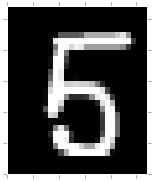

5


In [5]:
draw_digit(x_train[33456])
print(y_train[33456])

epoch 1
train mean loss=3.3561335449914136, accuracy=0.7222500002632538
test  mean loss=4.892250904178805, accuracy=0.7694000013172626
epoch 2
train mean loss=56.26083917617798, accuracy=0.5939333321154118
test  mean loss=37.42908650755882, accuracy=0.7550000013411045
epoch 3
train mean loss=189.95184919993082, accuracy=0.5882833315432072
test  mean loss=115.51796243332326, accuracy=0.7191000007838011
epoch 4
train mean loss=395.540954691569, accuracy=0.5961666659017404
test  mean loss=108.700798445642, accuracy=0.838600001335144
epoch 5
train mean loss=605.5116298929851, accuracy=0.612766666362683
test  mean loss=392.3828821563721, accuracy=0.7173000020161271
epoch 6
train mean loss=875.0841250101726, accuracy=0.6208166652421157
test  mean loss=328.1500767636299, accuracy=0.7960000003874302
epoch 7
train mean loss=1197.6624294026692, accuracy=0.6240666672090689
test  mean loss=660.9412345075607, accuracy=0.7541999995708466
epoch 8
train mean loss=1460.1671019999187, accuracy=0.6390333

[]

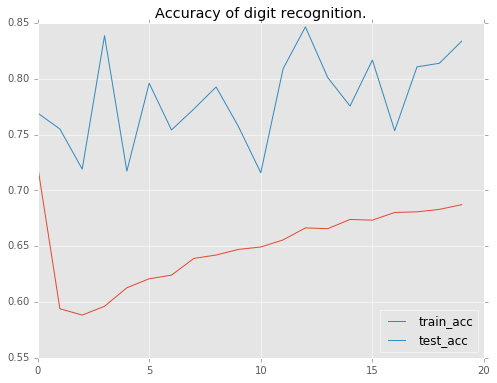

In [6]:
train_loss = []
train_acc  = []
test_loss = []
test_acc  = []

l1_W = []
l2_W = []
l3_W = []

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print ('epoch', epoch)

    # training
    # N個の順番をランダムに並び替える
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    # 0〜Nまでのデータをバッチサイズごとに使って学習
    for i in six.moves.range(0, N, batchsize):
        x_batch = x_train[perm[i:i+batchsize]]
        y_batch = y_train[perm[i:i+batchsize]]

        # 勾配を初期化
        optimizer.zero_grads()
        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch)
        # 誤差逆伝播で勾配を計算
        loss.backward()
        optimizer.update()
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # 訓練データの誤差と、正解精度を表示
    print ('train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N))

    train_loss.append(sum_loss / N)
    train_acc.append(sum_accuracy / N)

    # evaluation
    # テストデータで誤差と、正解精度を算出し汎化性能を確認
    sum_accuracy = 0
    sum_loss     = 0
    for i in six.moves.range(0, N_test, batchsize):
        x_batch = x_test[i:i+batchsize]
        y_batch = y_test[i:i+batchsize]

        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch, train=False)

        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # テストデータでの誤差と、正解精度を表示
    print('test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test))
    test_loss.append(sum_loss / N_test)
    test_acc.append(sum_accuracy / N_test)

    # 学習したパラメーターを保存
    l1_W.append(model.l1.W)
    l2_W.append(model.l2.W)
    l3_W.append(model.l3.W)


[]

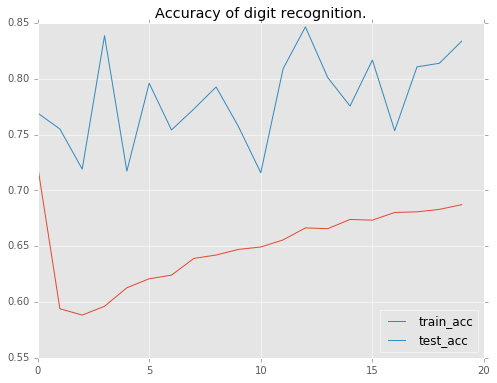

In [23]:
# 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.plot()

In [7]:
# Save the model and the optimizer
print('save the model')
serializers.save_npz('mnist.model', model)
print('save the optimizer')
serializers.save_npz('mnist.state', optimizer)

save the model
save the optimizer


In [8]:
# load the model and the optimizer
model = FunctionSet(l1=F.Linear(784, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 10))
optimizer = optimizers.Adam()
optimizer.setup(model)
print('load the model')
serializers.load_npz('mnist.model',  model)
print('load the optimizer')
serializers.load_npz('mnist.state', optimizer)

load the model
load the optimizer


[3]


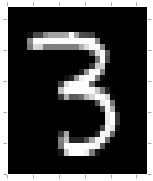

index: 0  val: 886383.0
index: 1  val: 976632.0
index: 2  val: 976084.0
index: 3  val: 1.03096e+06
index: 4  val: 893419.0
index: 5  val: 977700.0
index: 6  val: 840874.0
index: 7  val: 941588.0
index: 8  val: 981431.0
index: 9  val: 975641.0
result: 3


In [22]:
perm = np.random.permutation(N)
print(y_train[perm[5:6]])
draw_digit(x_train[perm[5:6]])


x = Variable(x_train[perm[5:6]])
#x = Variable(x_train[[27034]])

h1 = F.dropout(F.relu(model.l1(x)),  train=False)
h2 = F.dropout(F.relu(model.l2(h1)), train=False)
y  = model.l3(h2)
y.data
#perm[5:6]
#y

max = None
index = -1
for i in range(len(y.data[0])):
    print("index:" , i , " val:" , y.data[0][i])
    if max == None or  y.data[0][i] > max:
        max = y.data[0][i] 
        index = i
print("result:", index)